In [2]:
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import pandas as pd
from scipy.optimize import minimize

In [932]:
data = np.load('../../../source_synphot/caspec_mags.npy',allow_pickle=True).item()
data = pd.DataFrame(data)
red = np.load('../../../source_synphot/caspec_mags_av3p1.npy',allow_pickle=True).item()
red = pd.DataFrame(red)
# restrict to the MS section of the stellar locus
ind = (data['r'].values-data['i'].values) < 0.3
#data = data.iloc[ind]

good = []
for i in range(len(data['name'])):
    if 'ngc6681' not in data['name'].iloc[i]:
        good += [i]
good = np.array(good)
data = data.iloc[good]
gr = data['g'].values-data['r'].values
ind = (gr < 1)
data = data.iloc[ind]

## assume zeropoint of 25

In [530]:
data['name'].iloc[ind]

16    g191b2b_stisfuse_001
Name: name, dtype: object

In [428]:
def mag2flux(mag,zp):
    f = 10**(2/5*(zp-mag))
    return f

In [571]:
data

,g,r,i,z,y,kep,tess,name
0,16.448833,16.824855,17.193941,17.469483,17.703807,16.787205,17.207572,hs2027_stis_005
1,9.278681,9.771373,10.171662,10.469041,10.688448,9.689357,10.184255,bd_75d325_stis_005
2,16.984610,17.193064,17.418678,17.571332,17.448099,17.171691,17.387602,sdss132811_stis_003
3,14.527466,13.733931,12.486512,11.917067,11.668695,13.262748,12.340525,hz43b_stis_005
4,7.962748,7.644969,7.559345,7.557648,7.557790,7.703916,7.576214,hd38949_stis_005
...,...,...,...,...,...,...,...,...
90,12.232961,12.503453,12.776003,13.005722,13.171957,12.472957,12.810567,wd1327_083_stiswfc_003
91,7.483706,7.563091,7.683774,7.763686,7.780774,7.569961,7.686185,hd2811_stis_002
92,16.211254,16.669703,17.047354,17.349198,17.574212,16.597501,17.069956,wd1657_343_stiswfcnic_003
93,12.225922,12.374392,12.560075,12.734734,12.875551,12.376653,12.590816,gj7541a_stis_004


In [676]:
zp = 25
g = mag2flux(data['g'].values,zp)
r = mag2flux(data['r'].values,zp)
i = mag2flux(data['i'].values,zp)
z = mag2flux(data['z'].values,zp)
y = mag2flux(data['y'].values,zp)
k = mag2flux(data['kep'].values,zp)
t = mag2flux(data['tess'].values,zp)

<IPython.core.display.Javascript object>


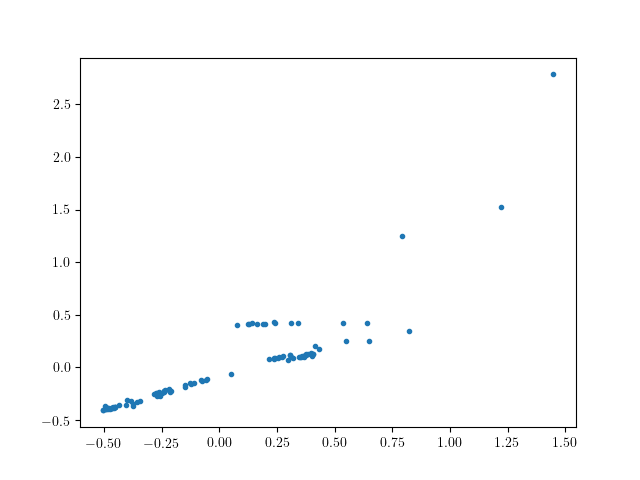

In [677]:
plt.figure()
plt.plot(data['g']-data['r'],data['r']-data['i'],'.')

In [496]:

def t_linear_combo(c,mag):
    g = mag2flux(data['g'],zp)
    r = mag2flux(data['r'],zp)
    i = mag2flux(data['i'],zp)
    z = mag2flux(data['z'],zp)
    y = mag2flux(data['y'],zp)
    #fit = c[0]*g + c[1]*r + c[2]*i + c[3]*z + c[4]*y + c[5]*(g-r)
    fit = (c[0]*g + c[1]*r + c[2]*i + c[3]*z + c[4]*y)*(g/r)**c[5]
    return fit 

def t_minimizer(c,mag):
    k = data['tess']
    fit = -2.5*np.log10(t_linear_combo(c,mag)) + 25
    diff = abs(k-fit)
    res = np.nansum(diff)
    print(res)
    return res

def k_linear_combo(c,mag):
    g = mag2flux(data['g'],zp)
    r = mag2flux(data['r'],zp)
    i = mag2flux(data['i'],zp)
    z = mag2flux(data['z'],zp)
    #old
    #fit = c[0]*g + c[1]*r + c[2]*i + c[3]*z + c[4]*(g-r)
    #new
    fit = (c[0]*g + c[1]*r + c[2]*i + c[3]*z)*(g/r)**c[4]
    return fit 

def k_minimizer(c,mag):
    k = data['kep']
    fit = -2.5*np.log10(k_linear_combo(c,mag)) + 25
    diff = abs(k-fit)
    res = np.nansum(diff)
    return res

def r_linear_combo(c,mag,ext=None):
    zp = 25
    if ext is not None:
        ge = ext * 3.518
        ie = ext * 1.971
        ze = ext * 1.549
        re = ext * 2.617
    else:
        ge = 0
        ie = 0
        ze = 0
        re = 0
    g = mag2flux(mag['g']-ge,zp)
    i = mag2flux(mag['i']-ie,zp)
    z = mag2flux(mag['z']-ze,zp)
    fit = (c[0]*g + c[1]*i + c[2]*z)*(g/i)**c[3]
    return fit 

def r_comp(c,mag,ext=None):
    zp = 25
    if ext is not None:
        ge = ext * 3.518
        ie = ext * 1.971
        ze = ext * 1.549
        re = ext * 2.617
    else:
        ge = 0
        ie = 0
        ze = 0
        re = 0
    g = mag2flux(mag['g']-ge,zp)
    i = mag2flux(mag['i']-ie,zp)
    z = mag2flux(mag['z']-ze,zp)
    fit = (c[0]*g + c[1]*i + c[2]*z)*(g/i)**c[3]
    r = -2.5*np.log10(fit) + 25 + re
    return r


def r_linear_combo2(c,mag):
    g = mag2flux(mag['g'],zp)
    i = mag2flux(mag['i'],zp)
    fit = (0.5*g + 0.5*i)*(g/i)**c[0]
    return fit 

def r_minimizer(c,mag):
    k = data['r']
    fit = -2.5*np.log10(r_linear_combo(c,mag)) + 25
    diff = abs(k-fit)
    res = np.nansum(diff)
    return res

In [513]:
thing = pd.DataFrame(data)

In [514]:
c0 = [.25,.25,.25,.25,.25,1]
bds = [(0,1),(0,1),(0,1),(0,1),(0,1),(-100,100)]
res = minimize(t_minimizer,c0,args=thing,bounds=bds)

45.60838921833746
45.60838970654207
45.608389447997574
45.608389282555706
45.608389182506265
45.60838912352745
45.60838953963198
1074.8253401696643
1074.8253396775133
1074.8253399004302
1074.8253400478716
1074.8253402022724
1074.8253401479137
1074.825339830811
120.24825770118865
120.24825734510732
120.24825759683257
120.248257771585
120.24825788480997
120.2482579619689
120.24825736754961
29.653845548719396
29.653846464348206
29.65384637526165
29.653846339389965
29.65384633756457
29.653846360398997
29.653845524814663
39.6881197195602
39.68811824806677
39.68811856435589
39.68811877949891
39.68811891968141
39.68811899388158
39.68811954042984
10.912205951787085
10.912205624798414
10.912205935908066
10.912206150434201
10.91220629204177
10.912206393708166
10.912205628335515
9.799760221665727
9.799760537205858
9.79976020008007
9.799759967701974
9.799759813841531
9.79975970270609
9.799760542147872
3.0720871322991545
3.0720880167821036
3.072087913475819
3.07208789121664
3.072087907986875
3.0720

0.26237449732939666
0.2623746029912475
0.25558676956682724
0.2555872054652557
0.25558697888503445
0.25558683599598275
0.25558674140611437
0.2555866642476925
0.25558691863120764
0.23176696372725125
0.2317670858776406
0.2317669140194134
0.23176682419437888
0.23176677792346645
0.23176673653361313
0.23176704642586898
0.1966385782594422
0.19663865648818657
0.19663858316472016
0.19663854799921943
0.19663852909105728
0.19663850400594107
0.19663857063399526
0.35865146374685786
0.3586504922780396
0.35865068589763105
0.35865084998485663
0.3586509597599328
0.35865102001893945
0.35865137928534274
0.19376218177562876
0.1937618099338163
0.19376188493408542
0.19376192135822734
0.1937619228257237
0.193761894432658
0.19376212520178981
0.18060847924040502
0.18060819190793254
0.18060824982128132
0.18060830912511427
0.18060835498994088
0.18060837681765562
0.18060840057877314
0.18076453178834484
0.18076476349830273
0.18076462685766437
0.18076458601550804
0.18076456953327025
0.1807645478465556
0.18076460163

0.12377808356427167
0.12377811044684606
0.12377811858880783
0.12377812652379383
0.12377813335672094
0.12377813170235186
0.12354834426830408
0.12354831574240599
0.12354830633196201
0.12354828936164886
0.12354828219892156
0.12354827881552133
0.12354835260099861
0.12337020792962505
0.12337017533597816
0.1233701576865407
0.12337014878657904
0.12337015357040215
0.1233701618075802
0.1233702257206648
0.12275834404422525
0.12275823574814915
0.12275822408183323
0.12275821908191453
0.12275822683608162
0.12275823753760307
0.12275836723549993
0.12216551858960756
0.12216546863860955
0.12216547828692903
0.12216548160786189
0.12216549098041796
0.12216550248365543
0.1221655147184304
0.12297535651878988
0.12297530632110742
0.12297531536558814
0.12297530866208284
0.12297529378353467
0.12297527633752914
0.12297538160875199
0.1221973443078177
0.1221972941337377
0.12219730316725297
0.12219729645398658
0.12219728156920695
0.12219726412007326
0.12219736939777981
0.12215290526481226
0.12215285531314812
0.1221

In [28]:
res

      fun: 0.280552416215885
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.49001742,  2.3585228 ,  1.25381661,  0.55410947,  0.15184689,
       -0.62556609])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1344
      nit: 90
     njev: 192
   status: 0
  success: True
        x: array([ 0.00114629,  0.20022099,  0.48119872,  0.13753681,  0.17881836,
       -0.00253189])

In [29]:
test = t_linear_combo(res.x,data)

In [30]:
test = -2.5*np.log10(test) + 25

<IPython.core.display.Javascript object>


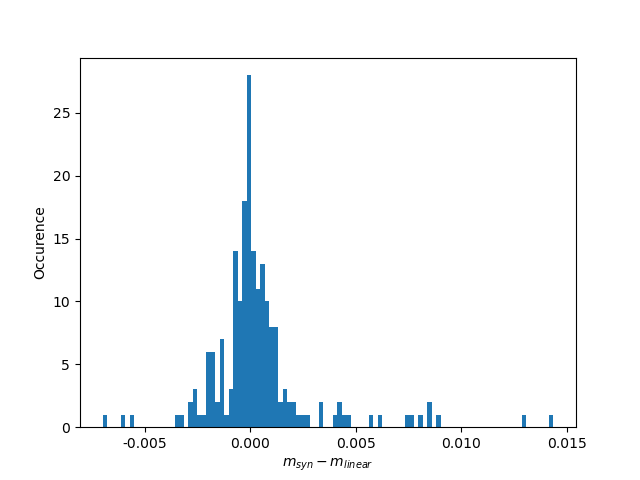

Text(0, 0.5, 'Occurence')

In [31]:
plt.figure()
plt.hist(data['tess']-test,bins=100)
plt.xlabel(r'$m_{syn}-m_{linear}$')
plt.ylabel('Occurence')

<IPython.core.display.Javascript object>


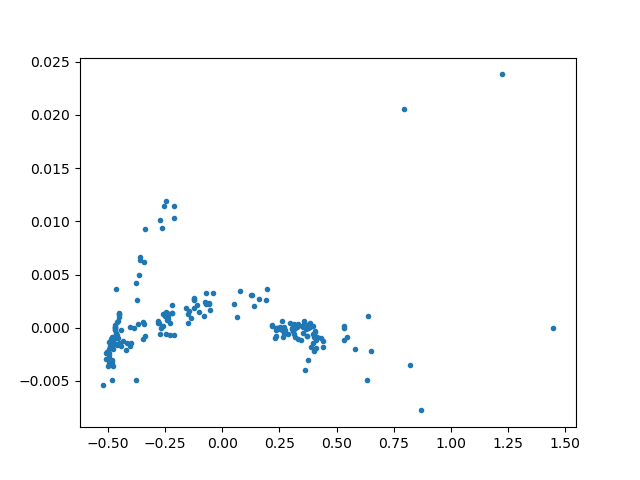

In [213]:
plt.figure()
plt.plot(data['g']-data['r'],test-data['kep'],'.')
#plt.plot(data['r']-data['i'],data['tess'],'.')
#plt.yscale('log')

<IPython.core.display.Javascript object>


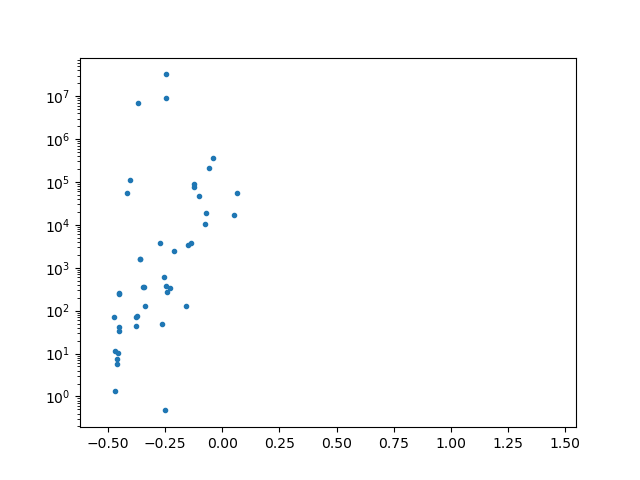

In [97]:
plt.figure()
plt.plot(data['g']-data['r'],k-test,'.')
#plt.plot(data['g']-data['r'],test,'.')
plt.yscale('log')

# Kepler

In [933]:
c0 = [.25,.25,.25,.25,1]
bds = [(0,1),(0,1),(0,1),(0,1),(-100,100)]
thing = pd.DataFrame(data)
res = minimize(k_minimizer,c0,args=thing,bounds=bds)

In [629]:
res

      fun: 0.13958823633457307
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.52417448, 0.75965581, 1.11560752, 3.66298654, 0.42234731])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 774
      nit: 32
     njev: 129
   status: 0
  success: True
        x: array([0.25114727, 0.45219539, 0.25765572, 0.04373212, 0.06550206])

In [433]:
0.37529951+  0.37586262+  0.19070184+0.05867781

1.00054178

In [934]:
test = k_linear_combo(res.x,data)
redtest = k_linear_combo(res.x,red)

In [935]:
test = -2.5*np.log10(test) + 25
redtest = -2.5*np.log10(redtest) + 25

In [936]:
from astropy.stats import sigma_clip
diff = data['kep']-test
reddiff = red['kep']-redtest
gr = data['g'].values-data['r'].values
ind = ~sigma_clip(diff).mask

In [937]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig_width_pt = 240.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]

<IPython.core.display.Javascript object>


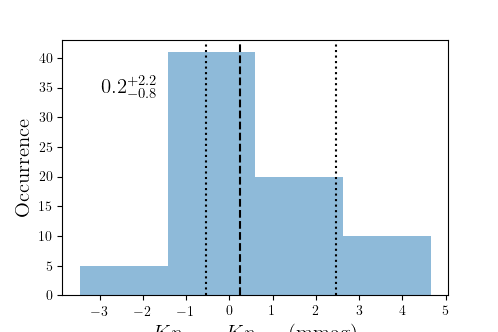

Text(0.1, 0.8, '$0.2^{+2.2}_{-0.8}$')

In [938]:
plt.figure(figsize=(1.5*fig_width,1*fig_width))
b = int(np.nanmax(diff[ind]) - np.nanmin(diff[ind]) /(2*iqr(diff[ind])*len(diff[ind])**(-1/3)))
plt.hist(diff[ind]*1e3,bins=b,alpha=0.5)
plt.xlabel(r'$Kp_{cal}-Kp_{com}$ (mmag)',fontsize=15)
plt.ylabel('Occurrence',fontsize=15)
med = np.percentile(diff[ind]*1e3,50)
low = np.percentile(diff[ind]*1e3,16)
high = np.percentile(diff[ind]*1e3,84)
plt.axvline(med,ls='--',color='k')
plt.axvline(low,ls=':',color='k')
plt.axvline(high,ls=':',color='k')

s = '$'+str(np.round(med,1))+'^{+' + str(np.round(high-med,1))+'}_{'+str(np.round(low-med,1))+'}$'
plt.annotate(s,(.1,.8),fontsize=15,xycoords='axes fraction')
#plt.savefig('PS1_com_residuals.pdf', bbox_inches = "tight")

<IPython.core.display.Javascript object>


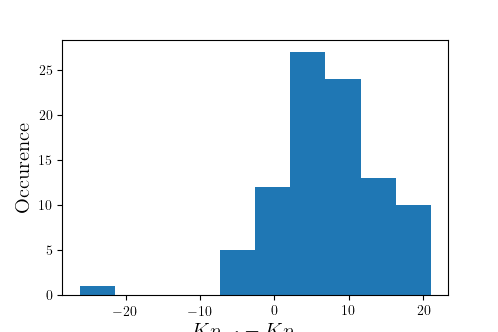

Text(0, 0.5, 'Occurence')

In [53]:
plt.figure(figsize=(1.5*fig_width,1*fig_width))
plt.hist(reddiff,bins=10)
plt.xlabel(r'$Kp_{cal}-Kp_{com}$',fontsize=15)
plt.ylabel('Occurence',fontsize=15)
#plt.savefig('PS1_com_residuals.pdf', bbox_inches = "tight")

In [289]:
np.nanmean(diff[ind])

0.00016482681332488584

In [278]:
np.nanstd(diff[ind])

0.0017669649892862625

In [269]:
np.nanstd(diff[ind])

0.0011050932415813922

# $\chi^2$ value

In [290]:
np.nansum((diff)**2/np.std(diff)**2)/len(test)

1.0240628894678552

<IPython.core.display.Javascript object>


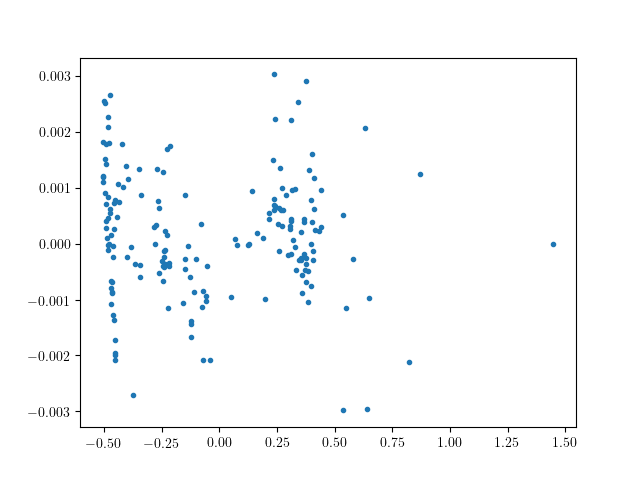

In [291]:
plt.figure()
plt.plot(gr[ind],diff[ind],'.')
plt.
#plt.plot(data['r']-data['i'],data['tess'],'.')
#plt.yscale('log')

# Test on r band

In [215]:
data

,g,r,i,z,y,kep,tess
0,10.250572,10.753361,11.161053,11.452185,11.472013,10.667424,11.145809
1,16.448833,16.824855,17.193941,17.469483,17.703807,16.787205,17.207572
2,13.926929,13.392862,12.989381,12.855744,12.794744,13.381352,13.005473
3,7.787699,7.500146,7.436906,7.447331,7.441391,7.559756,7.450458
4,9.278681,9.771373,10.171662,10.469041,10.688448,9.689357,10.184255
...,...,...,...,...,...,...,...
195,14.461439,13.593092,13.248671,13.088230,12.997659,13.661126,13.227376
196,13.224301,12.840287,12.711959,12.700891,12.700604,12.900481,12.735873
197,-26.536290,-26.932425,-27.043468,-27.049815,-27.061397,-26.862336,-27.026086
198,6.447291,6.546539,6.692978,6.810760,6.828029,6.554076,6.702639


In [939]:
c0 = [.3,.3,.3,0]
bds = [(0,1),(0,1),(0,1),(-100,100)]
#c0 = [.1]
#bds = [(-100,100)]
thing = pd.DataFrame(data)
#thing = thing.iloc[ri<.38]
res = minimize(r_minimizer,c0,args=thing,bounds=bds)

In [871]:
res

      fun: 1.9818562727138644
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([6.94364512, 4.57031406, 5.71063908, 2.25273365])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 485
      nit: 26
     njev: 97
   status: 0
  success: True
        x: array([0.05881705, 0.66085622, 0.35021584, 0.37704977])

In [940]:
test = r_linear_combo(res.x,data)
test = -2.5*np.log10(test) + 25
rdiff = data['r']-test
gr = data['g'].values-data['r'].values
ri = data['r'].values-data['i'].values
control = data['r']-data['i']
mask = ~sigma_clip(rdiff).mask

<IPython.core.display.Javascript object>


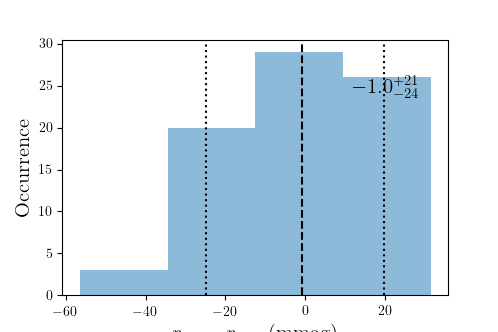

Text(0, 0.5, 'Occurrence')

In [941]:
plt.figure(figsize=(1.5*fig_width,1*fig_width))
b = int(np.nanmax(rdiff[ind]) - np.nanmin(rdiff[ind]) /(2*iqr(rdiff[ind])*len(rdiff[ind])**(-1/3)))
plt.hist(rdiff[mask]*1e3,bins=b,alpha=0.5)
#plt.hist(control[~mask],bins=10)
#plt.hist(kdiff[ind],bins=10)
med = np.percentile(rdiff[mask]*1e3,50)
low = np.percentile(rdiff[mask]*1e3,16)
high = np.percentile(rdiff[mask]*1e3,84)
plt.axvline(med,ls='--',color='k')
plt.axvline(low,ls=':',color='k')
plt.axvline(high,ls=':',color='k')

s = '$'+str((np.round(med,0)))+'^{+' + str(int(np.round(high-med,0)))+'}_{'+str(int(np.round(low-med,0)))+'}$'
plt.annotate(s,(.75,.8),fontsize=15,xycoords='axes fraction')

plt.xlabel(r'$r_{cal}-r_{com}$ (mmag)',fontsize=15)
plt.ylabel('Occurrence',fontsize=15)
#plt.savefig('PS1_com_r_res.pdf', bbox_inches = "tight")

<IPython.core.display.Javascript object>


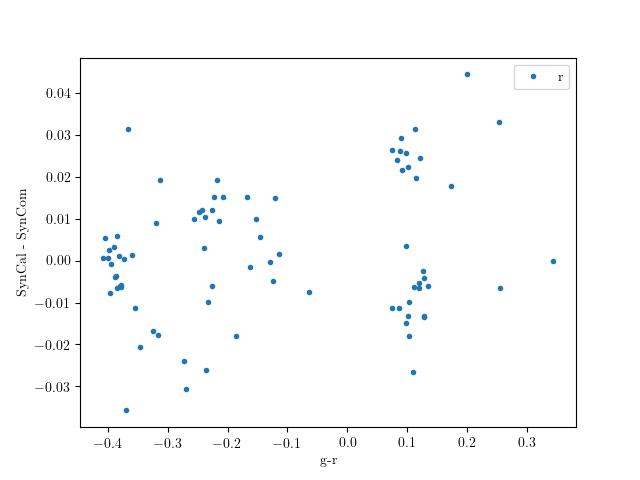

In [874]:
plt.figure()
plt.plot(ri[mask],rdiff[mask],'.',label='r')
#plt.plot(gr,kdiff,'.',label='kep')
plt.xlabel('g-r')
plt.ylabel('SynCal - SynCom')
plt.legend()
plt.savefig('r_composite.png')

In [495]:
np.where((ri > .38) & (ri < 0.45))

(array([  2,  17,  19,  31,  32,  37,  49,  50,  66,  68,  86, 137, 163,
        193, 194]),)

In [66]:
eh = pd.read_csv('../../../calibration/calspec_coords.csv')

In [65]:
eh.to_csv('../../../calibration/calspec.csv',index=False)

# test red on sources

In [664]:
import sys
sys.path.append('../../../source_synphot/')
from tools import *

In [881]:
obs = pd.read_csv('../../../calibration/kepler/K2_all_PS1_psc_ev_crowding.csv')
obs = pd.read_csv('../../../source_synphot/K2_all_PS1_psc_ev_crowding_sdss_gaia.csv')

obs = obs.iloc[(obs['PDC'].values > 0)]

obs['kMeanPSFMag'] = -2.5*np.log10(obs['PDC'].values)
obs['kMeanPSFMagErr'] = 0.01#(-2.5 / np.log(10)) * (obs['PDCe'].values / obs['PDC'].values) #0.05#np.abs(obs['PDCe'].values) / np.abs(obs['PDC'].values)/10
#obs = obs.iloc[abs(obs['kMeanPSFMagErr'].values) < 0.1] 
diff = abs(obs['rMeanPSFMag'].values - obs['crMeanPSFMag'].values)
ind = diff < 1

obs = obs.iloc[ind]

ind = ((abs(obs['zMeanPSFMagErr'].values) < 0.5) & 
       (abs(obs['gMeanPSFMagErr'].values) < 0.5) & 
       (abs(obs['rMeanPSFMagErr'].values) < 0.5) & 
       (abs(obs['iMeanPSFMagErr'].values) < 0.5))
obs = obs.iloc[ind]
cind =  ((obs['campaign'].values == 16))
c16 = obs.iloc[cind]

cind =  ((obs['campaign'].values == 4))
c2 = obs.iloc[cind]

c4ext = np.load('../../../source_synphot/c4_ext.npy')
#ex, obs = Tonry_reduce(obs)

In [882]:
g = obs['gMeanPSFMag'].values
r = obs['rMeanPSFMag'].values
i = obs['iMeanPSFMag'].values
z = obs['zMeanPSFMag'].values

ind = (g-r < 0.9)
dist = obs.iloc[ind]
obs = {'g':g[ind],'r':r[ind],'i':i[ind],'z':z[ind]}

g = c16['gMeanPSFMag'].values
r = c16['rMeanPSFMag'].values
i = c16['iMeanPSFMag'].values
z = c16['zMeanPSFMag'].values

ind = (g-r < 0.9)
d16 = c16.iloc[ind]
c16 = {'g':g[ind],'r':r[ind],'i':i[ind],'z':z[ind]}

g = c2['gMeanPSFMag'].values
r = c2['rMeanPSFMag'].values
i = c2['iMeanPSFMag'].values
z = c2['zMeanPSFMag'].values

ind = (g-r < 0.9)
d2 = c2.iloc[ind]
c2 = {'g':g[ind],'r':r[ind],'i':i[ind],'z':z[ind]}

In [883]:
from astropy.coordinates import SkyCoord
from dustmaps.bayestar import BayestarQuery
import astropy.units as u

In [884]:
bayestar = BayestarQuery()
coords = SkyCoord(dist.RAJ2000.values*u.deg,dist.DecJ2000.values*u.deg,
                  distance=dist.gaia_med.values*u.pc, frame='icrs')
med = bayestar(coords, mode='median')

coords = SkyCoord(d16.RAJ2000.values*u.deg,d16.DecJ2000.values*u.deg,
                  distance=d16.gaia_med.values*u.pc, frame='icrs')
med16 = bayestar(coords, mode='median')

coords = SkyCoord(d2.RAJ2000.values*u.deg,d2.DecJ2000.values*u.deg,
                  distance=d2.gaia_med.values*u.pc, frame='icrs')
med2 = bayestar(coords, mode='median')

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 39.121 s
  pix_info:   0.587 s
   samples:  25.225 s
      best:   5.390 s
       nan:   0.248 s
      sort:   7.431 s
       idx:   0.240 s


In [885]:
from copy import deepcopy

In [930]:
test = r_comp(res.x,obs,med)
#eh = r_comp(res.x,obs)
diff = (deepcopy(obs['r'])-test)#*1e3
#eh = (deepcopy(obs['r'])-eh)#*1e3
m = ~sigma_clip(diff).mask

test = r_comp(res.x,c16,med16)
diff16 = (c16['r']-test)#*1e3
m16 = ~sigma_clip(diff16).mask

test = r_comp(res.x,c2,med2)
diff2 = (c2['r']-test)#*1e3
m2 = ~sigma_clip(diff2).mask

In [887]:
from scipy.stats import iqr

<IPython.core.display.Javascript object>


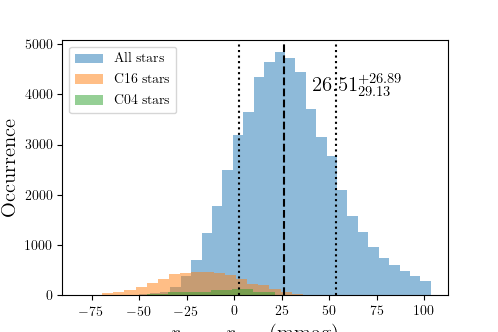

In [931]:
plt.figure(figsize=(1.5*fig_width,1*fig_width))
b = int(np.nanmax(diff[m]) - np.nanmin(diff[m]) /(2*iqr(diff[m])*len(diff[m])**(-1/3)))
a = plt.hist(diff[m]*1e3,bins=b, alpha=0.5,label='All stars')
#plt.axvspan(low,high,alpha = .3,color='orange')

b = int(np.nanmax(diff16[m16]) - np.nanmin(diff16[m16]) /(2*iqr(diff16[m16])*len(diff16[m16])**(-1/3)))
a = plt.hist(diff16[m16]*1e3,bins=b, alpha=0.5,label='C16 stars')

b = int(np.nanmax(diff2[m2]) - np.nanmin(diff2[m2]) /(2*iqr(diff2[m2])*len(diff2[m2])**(-1/3)))
a = plt.hist(diff2[m2]*1e3,bins=b, alpha=0.5,label='C04 stars')

med = np.percentile(diff[m]*1e3,50)
low = np.percentile(diff[m]*1e3,16)
high = np.percentile(diff[m]*1e3,84)


plt.axvline(med,ls='--',color='k')
plt.axvline(low,ls=':',color='k')
plt.axvline(high,ls=':',color='k')

s = '$'+str(np.round(med,2))+'^{+' + str(np.round(high-med,2))+'}_{'+str(np.round(low+med,2))+'}$'
plt.annotate(s,(.65,.8),fontsize=15,xycoords='axes fraction')

plt.legend(loc=2)
plt.ylabel('Occurrence',fontsize=15)
plt.xlabel('$r_{obs}-r_{com}$ (mmag)',fontsize=15)
plt.savefig('robs-rcom.png', bbox_inches = "tight")

In [740]:
gr = obs['g'] - obs['r']

In [889]:
eh = r_comp(res.x,deepcopy(obs))
eh = (deepcopy(obs['r'])-eh)#*1e3

<IPython.core.display.Javascript object>


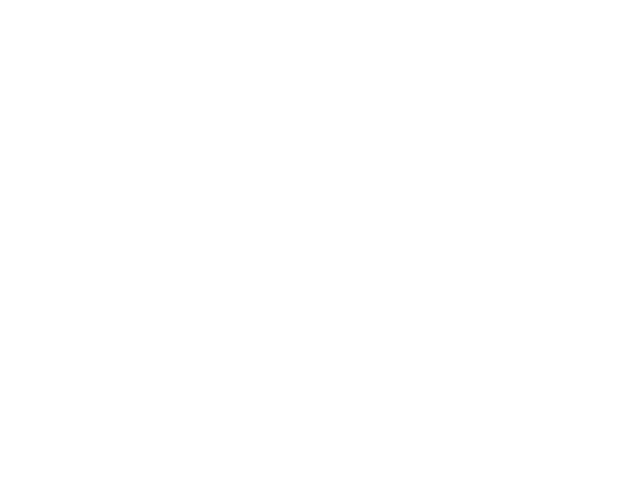

IndexError: boolean index did not match indexed array along dimension 0; dimension is 83 but corresponding boolean dimension is 55861

In [892]:
plt.figure()
plt.plot(gr[m],eh[m],'.')
plt.plot(gr[m],diff[m],'.',ms=1,alpha=.5)
plt.xlabel('')

67834

In [641]:
len(data)

83

In [419]:
np.percentile(diff16[m16],50) - np.percentile(diff2[m2],50)

-0.0278960078961763

In [237]:
grcal = data['g'].values-data['r'].values

<IPython.core.display.Javascript object>


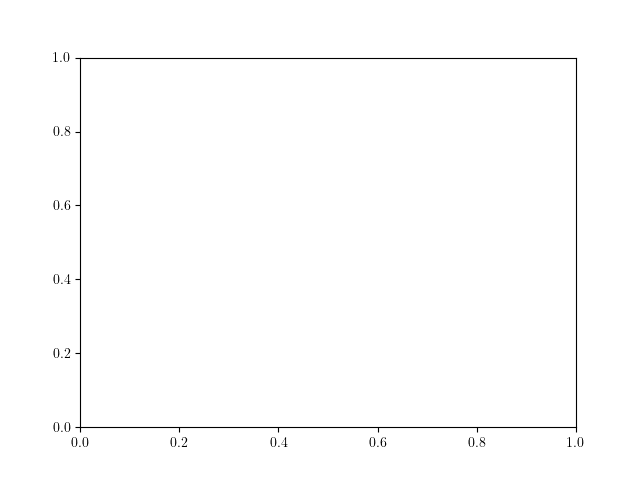

ValueError: x and y must have same first dimension, but have shapes (142299,) and (72387,)

In [259]:
plt.figure()
plt.plot((g-r),diff,'.')
#plt.plot(grcal,rdiff,'.')

# fit to PS1 obs data

In [923]:
def r_linear_combo(c,mag,ext=None):
    zp = 25
    if ext is not None:
        ge = ext * 3.518
        ie = ext * 1.971
        ze = ext * 1.549
        re = ext * 2.617
    else:
        ge = 0
        ie = 0
        ze = 0
        re = 0
    g = mag2flux(mag['g']-ge,zp)
    i = mag2flux(mag['i']-ie,zp)
    z = mag2flux(mag['z']-ze,zp)
    fit = (c[0]*g + c[1]*i + c[2]*z)*(g/i)**c[3]
    return fit 



def r_linear_combo2(c,mag,ext=None):
    zp = 25
    if ext is not None:
        ge = ext * 3.518
        ie = ext * 1.971
        ze = ext * 1.549
        re = ext * 2.617
    else:
        ge = 0
        ie = 0
        ze = 0
        re = 0
    g = mag2flux(mag['g']-ge,zp)
    i = mag2flux(mag['i']-ie,zp)
    z = mag2flux(mag['z']-ze,zp)
    fit = (.5*g + .5*i)*(g/i)**c[0]
    fit = -2.5*np.log10(fit) + 25
    return fit 

def r_minimizer(c,mag):
    k = data['r']
    fit = -2.5*np.log10(r_linear_combo(c,mag)) + 25
    diff = abs(k-fit)
    res = np.nansum(diff)
    return res

def r_minimizer2(c,mag):
    k = mag['r']
    fit = r_linear_combo2(c,mag)
    diff = abs(k-fit)
    res = np.nansum(diff)
    return res

In [900]:
len(c16['g'])

4787

In [924]:
c0 = [.3,.3,.3,1]
bds = [(0,1),(0,1),(0,1),(-100,100)]
res2 = minimize(r_data_minimizer,c0,args=c16,bounds=bds)

#c0 = [1]
#bds = [(-100,100)]
#res22 = minimize(r_minimizer2,c0,args=c16,bounds=bds)

In [925]:
data = r_comp(res2.x,c16,ext=med16)
#data2 = r_linear_combo2(res22.x,c16)
cal = r_comp(res.x,c16,ext=med16)

In [926]:
diff = c16['r']-cal
diff2 = c16['r']-data
diff22 = c16['r']-data2
m = ~sigma_clip(diff2).mask & ~sigma_clip(diff).mask

<IPython.core.display.Javascript object>


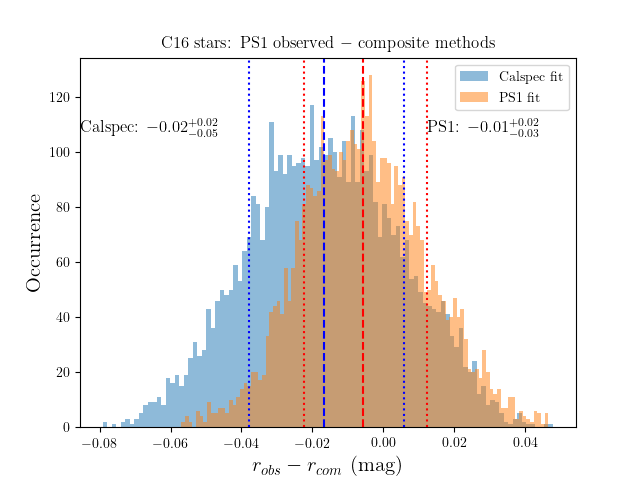

In [927]:
plt.figure()
plt.hist(diff[m],bins=100,alpha=.5,label='Calspec fit');
med = np.percentile(diff[m],50)
low = np.percentile(diff[m],16)
high = np.percentile(diff[m],84)

plt.axvline(med,ls='--',color='b')
plt.axvline(low,ls=':',color='b')
plt.axvline(high,ls=':',color='b')

s = 'Calspec: $'+str(np.round(med,2))+'^{+' + str(np.round(high-med,2))+'}_{'+str(np.round(low+med,2))+'}$'
plt.annotate(s,(0.001,.8),fontsize=12,xycoords='axes fraction')

plt.hist(diff2[m],bins=100,alpha=.5,label='PS1 fit');
med = np.percentile(diff2[m],50)
low = np.percentile(diff2[m],16)
high = np.percentile(diff2[m],84)

plt.axvline(med,ls='--',color='r')
plt.axvline(low,ls=':',color='r')
plt.axvline(high,ls=':',color='r')

s = 'PS1: $'+str(np.round(med,2))+'^{+' + str(np.round(high-med,2))+'}_{'+str(np.round(low+med,2))+'}$'
plt.annotate(s,(.7,.8),fontsize=12,xycoords='axes fraction')


#plt.hist(diff22[m],bins=100,alpha=.5,label='PS1 observed');
plt.legend()
plt.ylabel('Occurrence',fontsize=15)
plt.xlabel('$r_{obs}-r_{com}$ (mag)',fontsize=15)
plt.title('C16 stars: PS1 observed $-$ composite methods')
plt.savefig('calspecfit_vs_ps1datafit.png')

<IPython.core.display.Javascript object>


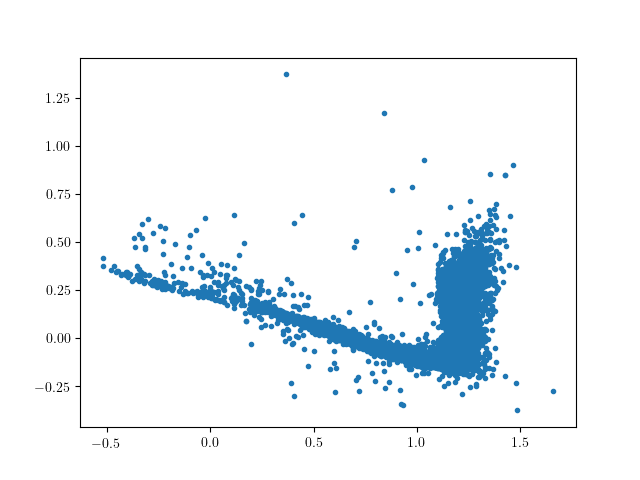

In [214]:
plt.figure()
plt.plot((g-r),diff,'.')